In [ ]:
import pandas as pd

In [ ]:
# Creating a empty dict, where I will save all parameters required for test data transformation

saved_dict = {}

In [ ]:
# Reading datasets
dfs = []
for i in range(1,5):
    path = '/content/drive/MyDrive/UNSW/CSV Files/UNSW-NB15_{}.csv'  # There are 4 input csv files
    dfs.append(pd.read_csv(path.format(i), header = None))
all_data = pd.concat(dfs).reset_index(drop=True)  # Concat all to a single df

<ipython-input-53-f9c534c03c56>:5: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv(path.format(i), header = None))
<ipython-input-53-f9c534c03c56>:5: DtypeWarning: Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv(path.format(i), header = None))


In [ ]:
# This csv file contains names of all the features
df_col = pd.read_csv('/content/drive/MyDrive/UNSW/CSV Files/NUSW-NB15_features.csv', encoding='ISO-8859-1')

In [ ]:
# Making column names lower case, removing spaces
df_col['Name'] = df_col['Name'].apply(lambda x: x.strip().replace(' ', '').lower())

In [ ]:
# Renaming our dataframe with proper column names
all_data.columns = df_col['Name']

In [ ]:
# Saving useful info, later this will be used to transform raw test data
saved_dict['columns'] = df_col['Name'][df_col['Name']!='label'].tolist()

In [ ]:
del df_col

In [ ]:
all_data.shape

(2540047, 49)

In [ ]:
all_data.head()

Name,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,...,0,3,7,1,3,1,1,1,NaN,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,0,2,4,2,3,1,1,2,NaN,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,0,12,8,1,2,2,1,1,NaN,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,0,6,9,1,1,1,1,1,NaN,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,0,7,9,1,1,1,1,1,NaN,0


In [ ]:
all_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2540047 entries, 0 to 2540046
Data columns (total 49 columns):
 #   Column            Dtype  
---  ------            -----  
 0   srcip             object 
 1   sport             object 
 2   dstip             object 
 3   dsport            object 
 4   proto             object 
 5   state             object 
 6   dur               float64
 7   sbytes            int64  
 8   dbytes            int64  
 9   sttl              int64  
 10  dttl              int64  
 11  sloss             int64  
 12  dloss             int64  
 13  service           object 
 14  sload             float64
 15  dload             float64
 16  spkts             int64  
 17  dpkts             int64  
 18  swin              int64  
 19  dwin              int64  
 20  stcpb             int64  
 21  dtcpb             int64  
 22  smeansz           int64  
 23  dmeansz           int64  
 24  trans_depth       int64  
 25  res_bdy_len       int64  
 26  sjit          

## Data cleaning and pre-processing

In [ ]:
# Missing Data Handling Module

def myPreprocessor(dataframe, handling_method, target_label_name):
    df = dataframe
    method = handling_method
    label = target_label_name

    #importing libraries
    import numpy as np
    import pandas as pd
    from sklearn import preprocessing

    for i in range(df.shape[1]):
        n = df.iloc[:,i].isnull().sum()
        if n > 0:
            print("There is some missing values")
            print(df.iloc[:,i].name)
            if df.iloc[:,i].dtype == 'object':
                print('object')
                df.iloc[:,i]=df.iloc[:,i].fillna(df.iloc[:,i].mode()[0])
            else:
                print('numerical')

                if method == 'mean':
                    df.iloc[:,i]=df.iloc[:,i].fillna(df.iloc[:,i].mean())
                elif method == 'median':
                    df.iloc[:,i]=df.iloc[:,i].fillna(df.iloc[:,i].median())
                elif method == 'ffill':
                    df.iloc[:,i]=df.iloc[:,i].fillna(method = 'ffill')

# Label Encoder for converting categorical values to numerical values

    obj_features = []

    # Decide which categorical variables you want to use in model
    for col_name in df.columns:
        if df[col_name].dtypes == 'object':
            unique_cat = len(df[col_name].unique())
            print("Feature '{col_name}' has {unique_cat} unique categories".format(col_name=col_name, unique_cat=unique_cat))
            obj_features.append(col_name)

    label_encoder = preprocessing.LabelEncoder()

    k = df[obj_features].shape[1]

    for i in range(k):
        name=obj_features
        name[i]
        df[name[i]]= label_encoder.fit_transform(df[name[i]])


# Feature scaling - Normalization

    features_data=df.drop(label,axis=1)
    class_data=df[label]
    ###
    cols_name = features_data.columns

    minmax_scaler=preprocessing.MinMaxScaler()
    scaled =minmax_scaler.fit_transform(features_data)

    normalize_data = pd.DataFrame(scaled, columns = cols_name)

    return normalize_data, class_data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import preprocessing
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, initializers
from tensorflow.keras.utils import to_categorical
#from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from imblearn.over_sampling import SMOTE
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [ ]:
DATA_DIR = "/content/drive/MyDrive/UNSW/CSV Files/Training and Testing Sets/"
training_fname= "UNSW_NB15_training-set.csv"
testing_fname= "UNSW_NB15_testing-set.csv"

In [ ]:
df1 = pd.read_csv(DATA_DIR + training_fname)
df2 =  pd.read_csv(DATA_DIR  + testing_fname)
df_ori = pd.concat([df1, df2], ignore_index=True)

In [ ]:
df = df_ori.copy()

In [ ]:
df

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257668,82328,0.000005,udp,-,INT,2,0,104,0,200000.005100,...,1,2,0,0,0,2,1,0,Normal,0
257669,82329,1.106101,tcp,-,FIN,20,8,18062,354,24.410067,...,1,1,0,0,0,3,2,0,Normal,0
257670,82330,0.000000,arp,-,INT,1,0,46,0,0.000000,...,1,1,0,0,0,1,1,1,Normal,0
257671,82331,0.000000,arp,-,INT,1,0,46,0,0.000000,...,1,1,0,0,0,1,1,1,Normal,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257673 entries, 0 to 257672
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 257673 non-null  int64  
 1   dur                257673 non-null  float64
 2   proto              257673 non-null  object 
 3   service            257673 non-null  object 
 4   state              257673 non-null  object 
 5   spkts              257673 non-null  int64  
 6   dpkts              257673 non-null  int64  
 7   sbytes             257673 non-null  int64  
 8   dbytes             257673 non-null  int64  
 9   rate               257673 non-null  float64
 10  sttl               257673 non-null  int64  
 11  dttl               257673 non-null  int64  
 12  sload              257673 non-null  float64
 13  dload              257673 non-null  float64
 14  sloss              257673 non-null  int64  
 15  dloss              257673 non-null  int64  
 16  si

In [ ]:

# 2. df1에만 있는 피처 확인
only_in_df1 = all_data.columns.difference(df.columns)
print("Features only in df1:", only_in_df1)

Features only in df1: Index(['dintpkt', 'dmeansz', 'dsport', 'dstip', 'ltime', 'res_bdy_len',
       'sintpkt', 'smeansz', 'sport', 'srcip', 'stime'],
      dtype='object')


In [ ]:
def Remove_dump_values(data, cols):
    for col in cols:
        data[col] = np.where(data[col] == '-', np.nan, data[col])
    return data

In [ ]:
cols = all_data.columns
df = Remove_dump_values(all_data, cols)

In [ ]:
df

Name,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132.0,164.0,31.0,...,0,3.0,7.0,1.0,3.0,1.0,1.0,1.0,NaN,0.0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528.0,304.0,31.0,...,0,2.0,4.0,2.0,3.0,1.0,1.0,2.0,NaN,0.0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146.0,178.0,31.0,...,0,12.0,8.0,1.0,2.0,2.0,1.0,1.0,NaN,0.0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132.0,164.0,31.0,...,0,6.0,9.0,1.0,1.0,1.0,1.0,1.0,NaN,0.0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146.0,178.0,31.0,...,0,7.0,9.0,1.0,1.0,1.0,1.0,1.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2540042,59.166.0.5,33094,149.171.126.7,43433,tcp,FIN,0.087306,320.0,1828.0,31.0,...,,1.0,2.0,3.0,3.0,1.0,1.0,3.0,NaN,0.0
2540043,59.166.0.7,20848,149.171.126.4,21,tcp,CON,0.365058,456.0,346.0,31.0,...,2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,0.0
2540044,59.166.0.3,21511,149.171.126.9,21,tcp,CON,6.335154,1802.0,2088.0,31.0,...,2,2.0,2.0,4.0,2.0,2.0,2.0,2.0,NaN,0.0
2540045,59.166.0.9,35433,149.171.126.0,80,tcp,CON,2.200934,3498.0,166054.0,31.0,...,,1.0,1.0,2.0,4.0,2.0,2.0,2.0,NaN,0.0


In [ ]:
# attack_cat 열에서 Backdoor 값을 Backdoors로 변경
df['attack_cat'] = df['attack_cat'].replace('Backdoor', 'Backdoors')

In [ ]:
df['ct_flw_http_mthd'] = df.ct_flw_http_mthd.fillna(value=0)

In [ ]:
df['is_ftp_login'] = (df.is_ftp_login.fillna(value=0)).astype(int)

In [ ]:
df.isnull().sum()

,0
Name,
srcip,0
sport,2
dstip,0
dsport,7
proto,0
state,0
dur,0
sbytes,0
dbytes,0


In [ ]:
df.drop(['sport', 'dsport', 'attack_cat','service', 'ct_ftp_cmd', 'srcip', 'dstip'], axis=1, inplace = True)

In [ ]:
df.isnull().sum()

,0
Name,
srcip,0
dstip,0
proto,0
state,0
dur,0
sbytes,0
dbytes,0
sttl,0
dttl,0


In [ ]:
x, y = myPreprocessor(df, 'mean', 'label')

In [ ]:
x

Name,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,sload,...,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm
0,0.895522,0.133333,1.200687e-07,0.000009,0.000011,0.121569,0.114173,0.000000,0.000000,8.357948e-05,...,0.0,0.000000,0.0,0.030303,0.090909,0.000000,0.030303,0.000000,0.000000,0.000000
1,0.895522,0.133333,4.112267e-06,0.000037,0.000021,0.121569,0.114173,0.000000,0.000000,1.464196e-05,...,0.0,0.000000,0.0,0.015152,0.045455,0.015152,0.030303,0.000000,0.000000,0.015152
2,0.895522,0.133333,1.273525e-07,0.000010,0.000012,0.121569,0.114173,0.000000,0.000000,8.715673e-05,...,0.0,0.000000,0.0,0.166667,0.106061,0.000000,0.015152,0.015152,0.000000,0.000000
3,0.895522,0.133333,1.375953e-07,0.000009,0.000011,0.121569,0.114173,0.000000,0.000000,7.293329e-05,...,0.0,0.000000,0.0,0.075758,0.121212,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.895522,0.133333,1.330429e-07,0.000010,0.000012,0.121569,0.114173,0.000000,0.000000,8.342890e-05,...,0.0,0.000000,0.0,0.090909,0.121212,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2540042,0.850746,0.333333,9.936224e-06,0.000022,0.000125,0.121569,0.114173,0.000188,0.000363,4.085783e-06,...,0.0,0.000000,0.0,0.000000,0.015152,0.030303,0.030303,0.000000,0.000000,0.030303
2540043,0.850746,0.133333,4.154695e-05,0.000032,0.000024,0.121569,0.114173,0.000376,0.000363,1.460223e-06,...,0.0,0.000000,0.5,0.015152,0.015152,0.015152,0.015152,0.015152,0.016949,0.015152
2540044,0.850746,0.133333,7.209987e-04,0.000126,0.000142,0.121569,0.114173,0.001316,0.001634,3.682097e-07,...,0.0,0.000000,0.5,0.015152,0.015152,0.045455,0.015152,0.015152,0.016949,0.015152
2540045,0.850746,0.133333,2.504865e-04,0.000244,0.011329,0.121569,0.114173,0.000376,0.010350,2.086926e-06,...,0.0,0.055556,0.0,0.000000,0.000000,0.015152,0.045455,0.015152,0.016949,0.015152


In [ ]:
print(x.head())

Name     proto     state           dur    sbytes    dbytes      sttl  \
0     0.895522  0.133333  1.200687e-07  0.000009  0.000011  0.121569   
1     0.895522  0.133333  4.112267e-06  0.000037  0.000021  0.121569   
2     0.895522  0.133333  1.273525e-07  0.000010  0.000012  0.121569   
3     0.895522  0.133333  1.375953e-07  0.000009  0.000011  0.121569   
4     0.895522  0.133333  1.330429e-07  0.000010  0.000012  0.121569   

Name      dttl  sloss  dloss     sload  ...  ct_state_ttl  ct_flw_http_mthd  \
0     0.114173    0.0    0.0  0.000084  ...           0.0               0.0   
1     0.114173    0.0    0.0  0.000015  ...           0.0               0.0   
2     0.114173    0.0    0.0  0.000087  ...           0.0               0.0   
3     0.114173    0.0    0.0  0.000073  ...           0.0               0.0   
4     0.114173    0.0    0.0  0.000083  ...           0.0               0.0   

Name  is_ftp_login  ct_srv_src  ct_srv_dst  ct_dst_ltm  ct_src_ltm  \
0              0.0    

In [ ]:
y.value_counts()

,count
label,
0.0,2218764
1.0,321283


## Data Visualization

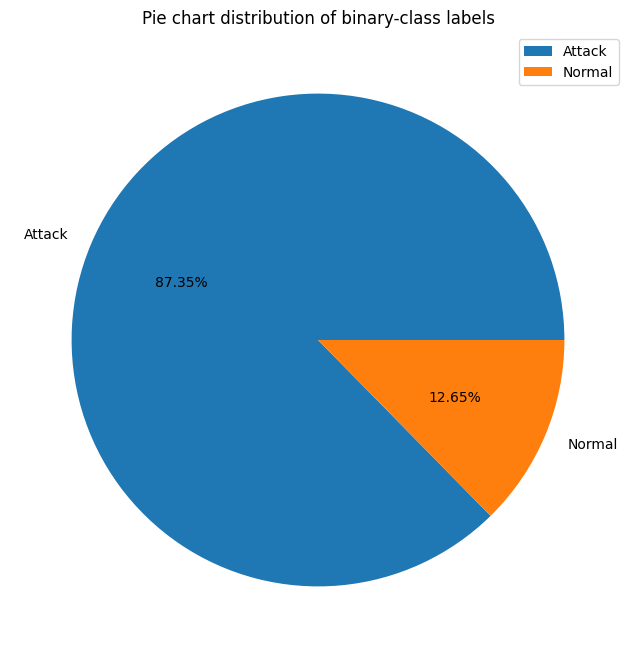

In [ ]:
plt.figure(figsize=(8,8))
#plt.pie(y.value_counts(),labels=df.attack_cat.unique(),autopct='%0.2f%%')
plt.pie(y.value_counts(),labels=['Attack','Normal'],autopct='%0.2f%%')
plt.title('Pie chart distribution of binary-class labels')
plt.legend(loc='best')
plt.show()

In [ ]:
x_array = np.array(x)
y_array = np.array(y)

In [ ]:
x_3d =np.expand_dims(x_array, axis =2)

In [ ]:
unique, counts = np.unique(y_array, return_counts=True)

dict(zip(unique, counts))

{0.0: 2218764, 1.0: 321283}

## Model

In [ ]:
cnn = models.Sequential([
    layers.Conv1D(32,3,activation='relu',padding='same', kernel_initializer='he_uniform', input_shape = (41, 1)),
    layers.Conv1D(32,3,activation='relu',padding='same',kernel_initializer='he_uniform'),
    layers.MaxPooling1D(pool_size=2,strides=2),

    layers.Dropout(0.2),
    layers.BatchNormalization(),

    layers.Conv1D(64,3,activation='relu',padding='same',kernel_initializer='he_uniform'),
    layers.Conv1D(64,3,activation='relu',padding='same',kernel_initializer='he_uniform'),
    layers.MaxPooling1D(pool_size=2,strides=2),
    layers.Dropout(0.2),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(32,activation='relu'),
    layers.Dense(1,activation='sigmoid'),   #UNSW-NB15 is 2 and 10,CICIDS2017 is 15
])

cnn.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 41, 32)              │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 41, 32)              │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 20, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 20, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 20, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 20, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 10, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 640)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │          20,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,721 (166.88 KB)

 Trainable params: 42,529 (166.13 KB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
# 수정된 Nadam 옵티마이저 (schedule_decay 제거)
nadam = optimizers.Nadam(learning_rate=0.008, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

# 모델 컴파일
cnn.compile(optimizer=nadam, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, precision_score, f1_score
from tensorflow.keras.callbacks import ReduceLROnPlateau
import numpy as np

n_epochs = 15
batch_size = 256
verbosity = 1

# 결과 저장을 위한 리스트 초기화
model_history = []
clr = []
cm_all = []
acc_all = []
loss_all = []
recall_all = []
precision_all = []
f1_all = []

# Reduce learning rate callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# 데이터를 80:10:10 비율로 나누기
# 불균형 데이터를 레이블 비율에 맞게 나누기 위해 stratify 옵션 사용
# 1단계: 먼저 80% train, 20% test/val로 나누기
x_train, x_temp, y_train, y_temp = train_test_split(x_3d, y_array, test_size=0.2, random_state=42, stratify=y_array)

# 2단계: 나머지 20%에서 50:50으로 다시 나누어 10% validation, 10% test로 나누기
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


In [ ]:
print(f'Training set size: {x_train.shape[0]} samples')
print(f'Validation set size: {x_val.shape[0]} samples')
print(f'Test set size: {x_test.shape[0]} samples')

Training set size: 2032037 samples
Validation set size: 254005 samples
Test set size: 254005 samples


In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1966419919158288954
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9705346031776260528
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [ ]:
import tensorflow as tf

# 첫 번째 GPU를 강제로 사용하도록 설정
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print("Using GPU:", gpus[0])
    except RuntimeError as e:
        print(e)


Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
# 학습 시작
print('------------------------------------------------------------------------')
print('Training the model...')

# 모델 훈련
history = cnn.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=n_epochs,
                  verbose=verbosity,
                  validation_data=(x_val, y_val),  # validation_split 대신 validation_data 사용
                  callbacks=[reduce_lr])

# 테스트 데이터로 성능 평가
scores = cnn.evaluate(x_test, y_test, verbose=0)
print(f'\nTest Score: {cnn.metrics_names[0]} of {scores[0]}; {cnn.metrics_names[1]} of {scores[1] * 100} %')

# 예측 및 성능 측정
y_preds = cnn.predict(x_test)
y_preds1 = np.round(y_preds)  # 예측값 반올림

# 분류 보고서 및 혼동 행렬 계산
clr = classification_report(y_test, y_preds1, target_names=['Normal', 'Attack'])
cm = confusion_matrix(y_test, y_preds1)
accuracy = accuracy_score(y_test, y_preds1)
recall = recall_score(y_test, y_preds1, average='weighted')
precision = precision_score(y_test, y_preds1, average='weighted')
f1 = f1_score(y_test, y_preds1, average='weighted')

# 결과 저장
model_history.append(history)
cm_all.append(cm)
acc_all.append(accuracy * 100)
loss_all.append(scores[0])
recall_all.append(recall)
precision_all.append(precision)
f1_all.append(f1)

# 결과 출력
print(f'Confusion Matrix:\n{cm}')
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1 Score: {f1:.2f}')


------------------------------------------------------------------------
Training the model...
Epoch 1/15
7938/7938 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - accuracy: 0.9914 - loss: 0.0169 - val_accuracy: 0.9915 - val_loss: 0.0168 - learning_rate: 0.0080
Epoch 2/15
7938/7938 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.9916 - loss: 0.0169 - val_accuracy: 0.9916 - val_loss: 0.0170 - learning_rate: 0.0080
Epoch 3/15
7938/7938 ━━━━━━━━━━━━━━━━━━━━ 34s 4ms/step - accuracy: 0.9915 - loss: 0.0167 - val_accuracy: 0.9915 - val_loss: 0.0168 - learning_rate: 0.0080
Epoch 4/15
7938/7938 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - accuracy: 0.9915 - loss: 0.0169 - val_accuracy: 0.9919 - val_loss: 0.0162 - learning_rate: 0.0080
Epoch 5/15
7938/7938 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.9915 - loss: 0.0169 - val_accuracy: 0.9917 - val_loss: 0.0165 - learning_rate: 0.0080
Epoch 6/15
7938/7938 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - accuracy: 0.9918 - loss: 0.0166 - val_accuracy: 0.9918 - val_loss: 0.0164

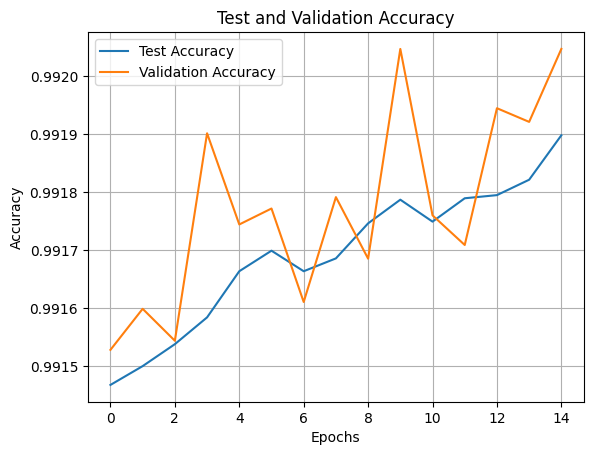

In [ ]:
# 훈련 및 검증 정확도 시각화
plt.plot(history.history['accuracy'], label='Test Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Test and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()